<a href="https://colab.research.google.com/github/fcignoli/Redes-Complejas-2-20222/blob/main/TP_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#Librerias necesarias
#!pip install nltk
!pip install PyPDF2

import nltk, string
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="darkgrid")
import networkx as nx
from PyPDF2 import PdfReader
import re       # libreria de expresiones regulares
import pandas as pd
nltk.download('punkt') # if necessary...
nltk.download("stopwords")

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 220 kB 4.9 MB/s 


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

# PDF --> Texto --> Limpieza

In [ ]:
def clean_text_round1(text):
    # pasa las mayusculas del texto a minusculas
    text = text.lower()
    # reemplaza texto entre corchetes por espacio en blanco.. ¿ y \% no se..
    text = re.sub('\[.*?¿\]\%', ' ', text)
    # reemplaza singnos de puntuacion por espacio en blanco.. %s -> \S+ es cualquier caracter que no sea un espacio en blanco
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    # remueve palabras que contienen numeros.
    text = re.sub('\w*\d\w*', '', text)
    return text

def clean_text_round2(text):
    # Sacamos comillas, los puntos suspensivos, <<, >>
    text = re.sub('[‘’“”…«»]', '', text)
    text = re.sub('\n', '', text)
    text = re.sub('–',"",text)
    text = re.sub('¿',"",text)
    text = re.sub(autor,"",text)
    text = re.sub(titulo,"",text)
    text = re.sub(r"\b\w{2,3}\b", "", text) #eliminamos palabras con dos o tes letras
    text = re.sub(r"\s+", " ", text) #eliminamos espacios en blanco extras
    return text

def pdfToText(filepath):
    """
    PDF ---> string
    """
    reader = PdfReader(filepath)
    number_of_pages = len(reader.pages)
    text = ''
    for i in range(number_of_pages):
        text+=reader.pages[i].extract_text()
    """
    Ahora limpiémoslo
    """
    text = clean_text_round1(text)
    text = clean_text_round2(text)
    return text
  

## TO-DO: ***textos*** ---> ***DataFrame***

In [ ]:
import os #para trabajar con la carpeta donde están todos los pdfs
from google.colab import drive
drive.mount('/content/drive')
"""
Link al drive donde subí los ejemplos: https://drive.google.com/drive/folders/1VKAZsJ38SXsidJzHprzUsKXWrakzoZ4H?usp=share_link
"""

"""
función que carga los textos a un dataframe "df" con las columnas texto titulo autor y año
"""
df = pd.DataFrame({"Text":[],
            "Title":[],
            "Author":[],
            "Age":[],
            'Grupo':[]},)
def textToDataFrame(texto,titulo,autor,ano,grupo):
    return df.append({"Text": texto,
            "Title": titulo,
            "Author": autor,
            "Age": ano , 
            'Grupo': grupo},
            ignore_index = True)

"""
La idea ahora es hacer un for loop que camine por nuestros archivos del drive donde están las obras
"""
for root, dirs, files in os.walk("/content/drive/My Drive/Literatura_Argentina"):
    for file in files:
        if file.endswith(".pdf"):
            if len(os.path.join(root, file).split("/")[-1].split("-")) == 4: # si la lista spliteada por '-' es igual a 4, es porque tiene atributo frupo.
              autor = os.path.join(root, file).split("/")[-1].split("-")[0]
              titulo = os.path.join(root, file).split("/")[-1].split("-")[1]
              ano = int(os.path.join(root, file).split("/")[-1].split("-")[2])
              grupo = os.path.join(root, file).split("/")[-1].split("-")[-1].split(".")[0] #entonces le agregamos el atributo grupo
            elif len(os.path.join(root, file).split("/")[-1].split("-")) == 3: # si la lista spliteada por '-' es igual a 3, es porque tiene atributo año.
              autor = os.path.join(root, file).split("/")[-1].split("-")[0]
              titulo = os.path.join(root, file).split("/")[-1].split("-")[1]
              ano = int(os.path.join(root, file).split("/")[-1].split("-")[-1].split(".")[0]) #entonces le agregamos el atributo año
              grupo = np.NaN
            else: # de lo contrario, le ponemos None
              autor = os.path.join(root, file).split("/")[-1].split("-")[0]
              titulo = os.path.join(root, file).split("/")[-1].split("-")[-1].split(".")[0]
              ano = np.NaN
              grupo = np.NaN
            try: 
              texto = pdfToText(os.path.join(root,file))
              df = textToDataFrame(texto,titulo,autor,ano,grupo) 
            except:
              print(os.path.join(root,file))
              pass

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/Literatura_Argentina/Echeverria, Esteban - El Dogma Socialista De La Juventud Argentina.pdf
/content/drive/My Drive/Literatura_Argentina/Echeverria, Esteban - Himno Al Dolor.pdf
/content/drive/My Drive/Literatura_Argentina/Sarmiento, Domingo F - Argirópolis - 1850.pdf


## Cortemos en diferentes épocas la red

In [ ]:
# Tomamos solo datos del siglo XX
df= df[(df['Age'] >= 1800) & (df['Age'] < 2000)].copy()

# Creamos una columna que sea la década a la cual pertenece
df['decada'] = ((df['Age'] % 100) // 10) * 10

# Limpiamos los datos sin información sobre la década
df.dropna(subset = ['decada'], inplace = True)

# Reseteamos el índice
df.reset_index(drop = True, inplace = True)

## De ***Textos*** a ***Redes*** 
versión Gian

(9727, 11)


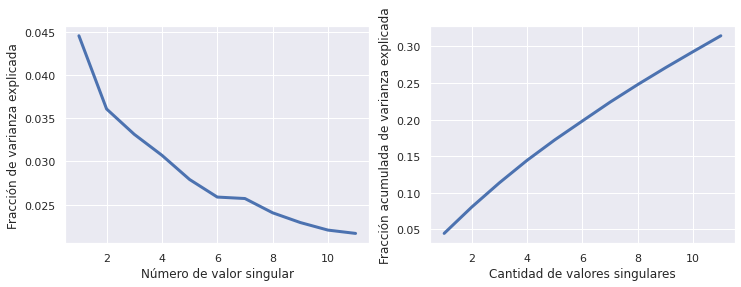

In [ ]:
# Objetos de sklearn para hacer LSA
from sklearn.feature_extraction.text import CountVectorizer # Contador de frecuencia
from sklearn.feature_extraction.text import TfidfTransformer # Creador de tf-idf
from sklearn.decomposition import TruncatedSVD # Singular Value Decomposition
# Lista de stopwords
stopwords = nltk.corpus.stopwords.words('spanish')
from scipy.spatial.distance import cosine as cosine_distance
import heapq
# Creamos el objeto contador de palabras, pidiéndole que remueve
# las stopwords, los términos que aparecen en un único documento (min_df)
# y los términos que aparecen en más del 70% de los documentos (max_df).
# Esto es para eliminar palabras raras (o errores de tipeo) y
# términos que seguramente son stopwords no incluídos en la lista
count = CountVectorizer(min_df = 8, max_df = 0.5, stop_words = stopwords)

# Ajustamos con los datos. Acá especificamente creamos una matriz documentos-términos
x_count = count.fit_transform(df['Text'])

# Dimensions de la matriz doc-tér
# print(x_count.shape)

# Creamos el objeto tf-idf. Le decimos además que devuelva los
# vectores documento con norma euclídea igual a 1 (norm = 'l2')
tfidf = TfidfTransformer(norm = 'l2')

# Creamos la matriz tf-idf a partir de la matriz de frecuencias
x_tfidf = tfidf.fit_transform(x_count)

# Dimensión del espacio reducido
n_components =11

# Creación del objeto SVD
svd = TruncatedSVD(n_components = n_components)

# Ajuste con los datos y descripción en el espacio reducido
# Trabajamos con la matriz traspuesta
x_svd = svd.fit_transform(x_tfidf.T)

# Dimensión de la matriz de datos en el espacio reducido
print(x_svd.shape)

# con .explained_variance_ratio_ vemos la fracción de información que aporta cada componente
evr = svd.explained_variance_ratio_

# Graficamos la fracción de varianza que aporta cada componente
# y la información acumulada
fig, ax = plt.subplots(1, 2, figsize = (12, 4))

ax[0].plot(range(1, len(evr) + 1), evr, '-', linewidth = 3)
ax[0].set_ylabel('Fracción de varianza explicada')
ax[0].set_xlabel('Número de valor singular')

# Calculamos el acumulado con la función cumsum de numpy
varianza_acumulada = np.cumsum(evr)

ax[1].plot(range(1, len(evr) + 1), varianza_acumulada, '-', linewidth = 3)
ax[1].set_ylabel('Fracción acumulada de varianza explicada')
ax[1].set_xlabel('Cantidad de valores singulares')
plt.show()




In [ ]:
from sklearn.feature_extraction import DictVectorizer

text = list(count.get_feature_names_out())
#text


In [ ]:
df

,Text,Title,Author,Age,decada
0,farsa tres actos sobre mujer dispuesta a casar...,Una viuda difícil,Conrado Nalé Roxlo,1944.0,40.0
1,adolfo bioy casares probablemente carlota tuv...,Noumeno,"Bioy, Casares Adolfo",1965.0,60.0
2,caso viejitos voladores adolfo bioy casares d...,El Caso De Los Viejitos Voladores,"Bioy, Casares Adolfo",1949.0,40.0
3,memoria paulina adolfo bioy casares siempre q...,En Memoria De Paulina,"Bioy, Casares Adolfo",1942.0,40.0
4,sseeiiss pprroobblleemmaass ppaarraa ddoonn i...,Seis problemas para don Isidro Parodi,"Bustos, Honorio Domecq",1942.0,40.0
5,digitalizado palabras liliana heker a primera...,Infierno Grande,"Martinez, Guillermo",1989.0,80.0
6,rodolfo enrique fogwillcantos marineros pampas...,Cantos De Marineros En Las Pampas,"Fogwill, Rodolfo Enrique",1998.0,90.0
7,tensa partida ajedrez adolescente derrotado u...,Acerca de Roderer,"Martínez, Guillermo",1992.0,90.0
8,rodolfo fogwill pichiciegos a andrés v francis...,Los pichiciegos,"Fogwill, Rodolfo Enrique",1983.0,80.0
9,borges bioy casares y silvina ocampo ofrecen ...,Antología de la literatura fantástica,"Bioy, Casares Adolfo . Borges, Jorge Luis . Oc...",1940.0,40.0


In [ ]:
labels_autores = {}
labels_año = {}
labels_titulo = {}
#labels_grupo = {}
for i in df.index:
  labels_autores.update({i:df['Author'][i]}) #Creamos un diccionario de índice - autor
  labels_año.update({i:df['Age'][i]})# índice - año
  labels_titulo.update({i:df['Title'][i]})
#  labels_grupo.update({i:df['Grupo'][i]})



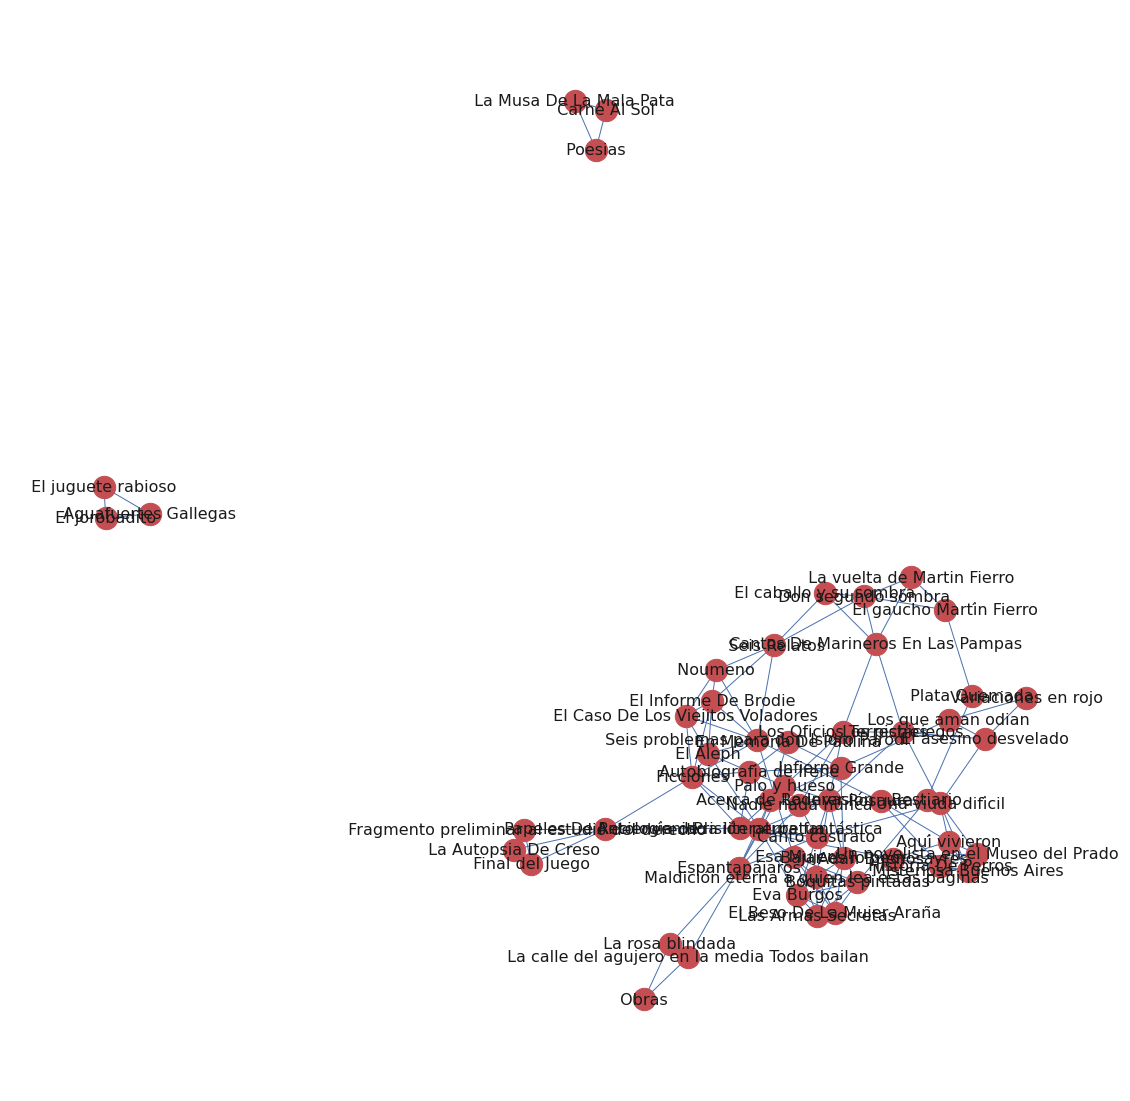

In [ ]:
red = []
for i in df['Text']:
    index = df[df['Text'] == i].index[0]
    similarities = [1.00 - cosine_distance(svd.components_.T[index], svd.components_.T[i]) for i in range(svd.components_.shape[1])]
    red.append(similarities)

matriz = np.array(red)

matriz = (1+matriz)/2
matriz[matriz < .77] = 0 # los que tienen una similaridad menor a 0.8, ledamos 0
matriz[matriz == 1] = 0
matriz[matriz >= .77] = 1 # los que tienen una similaridad mayor a 0.05, le damos 1. de esta manera lo binarizamos

G = nx.from_numpy_matrix(matriz, create_using = nx.Graph)

#pos = nx.layout.fruchterman_reingold_layout(G)

pos = nx.spring_layout(G)
fig, ax = plt.subplots(figsize = (20, 20))
ax.axis('off')
nx.draw_networkx_nodes(G, pos, node_color='r', node_size=500)
nx.draw_networkx_edges(G, pos, edge_color='b')
nx.draw_networkx_labels(G, pos, labels_titulo, font_size=16)

#nx.draw(G, with_labels=True)
plt.show()



## Análisis temporal

## Análisis de tópicos

In [ ]:
# Algoritmos de descomposición de tópicos
from sklearn.decomposition import NMF 
from sklearn.decomposition import LatentDirichletAllocation

In [ ]:
n_topic_components = 7
# Construímos el objeto NMF con los tópicos indicados 
nmf = NMF(n_components = n_topic_components)

# Aplicamos sobre nuestros datos
x_nmf = nmf.fit_transform(x_tfidf)

# Dimensión de la matriz transformada
print(x_nmf.shape)

/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_nmf.py:294: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  FutureWarning,


(57, 7)


In [ ]:
# Objeto índice: término de nuestro vocabulario
vocabulary = {item: key for key, item in count.vocabulary_.items()}

# Para cada componente
for n in range(n_topic_components):
  # Ordenamos una lista del largo de nuestro vocabulario según el peso en cada componente y nos quedamos con los primeros 10
  list_sorted = sorted(range(nmf.components_.shape[1]), reverse = True, key = lambda x: nmf.components_[n][x])[:10]

  # Printeamos los términos asociados a los valores más grande de cada una de las componentes
  print(', '.join([vocabulary[i] for i in list_sorted]))
  print('\n')

doña, adán, laberinto, francisco, embar, quinta, pedro, museo, isidro, caballero


musa, amada, nicolás, poesía, poema, poemas, infiel, sentimental, rabia, arrabal


gaucho, indio, tropa, pampa, usté, ande, estancia, fierro, poncho, rancho


mamá, nene, tenés, ramírez, querés, chino, auto, dora, raba, monsieur


comisario, daniel, pregunté, miré, asesino, montes, crimen, señorita, exclamó, recordé


arlt, roberto, gallego, rengo, enrique, novia, caballero, santiago, lucio, españa


oral, prim, tiem, ismo, bién, form, iento, enos, ento, siem




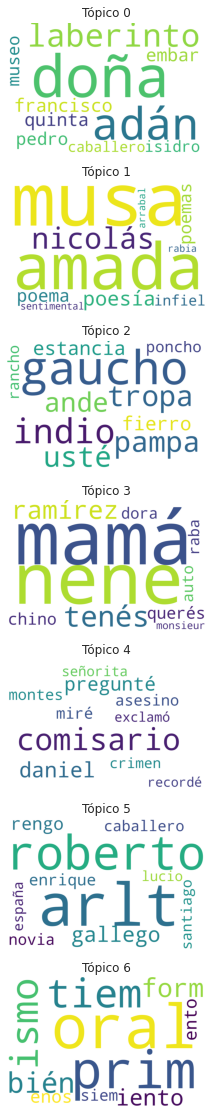

In [ ]:
# Librería para hacer wordclouds
from wordcloud import WordCloud

wc_atributos = {'height' : 800,
                'width' : 1200,
                'background_color' : 'white',
                'max_words' : 20
                } # Defino los parámetros que les voy a pasar a los wordclouds

# Creo la figura
fig, axs = plt.subplots(n_topic_components, figsize = (6,20))

# Recorro para todas las componentes
for n in range(n_topic_components):

  # 10 términos más pesados
  list_sorted = sorted(range(len(vocabulary)), reverse = True, key = lambda x: nmf.components_[n][x])[:10]

  # Diccionario término: peso
  comp_dict = {vocabulary[i]: nmf.components_[n][i] for i in list_sorted}

  # Creo el wordlcoud
  wc = WordCloud(**wc_atributos # De esta forma, le estoy diciendo a la función que expanda el diccionario de atributos de forma tal de que entienda lo que quiero que haga
                 ).generate_from_frequencies(comp_dict)

  axs[n].set_title('Tópico {}'.format(n))
  axs[n].imshow(wc)
  axs[n].axis('off')

plt.show()

In [ ]:
# Normalizador
from sklearn.preprocessing import Normalizer 

# Creamos un objeto para normalizar a que la suma dé 1
norm = Normalizer('l1')

# Sobreescribimos sobre la matriz de documentos-tópicos
x_nmf = norm.fit_transform(x_nmf)

# Guardemos en el dataframe esta información
for n in range(n_topic_components):
  df['nmf_comp{}'.format(n)] = x_nmf[:,n]



## Análisis temporal

In [ ]:
# Tomamos solo datos del siglo XX
df_sxx= df[(df['Age'] >= 1900) & (df['Age'] < 2000)].copy()

# Creamos una columna que sea la década a la cual pertenece
df_sxx['decada'] = ((df_sxx['Age'] % 100) // 10) * 10

# Limpiamos los datos sin información sobre la década
df_sxx.dropna(subset = ['decada'], inplace = True)

# Reseteamos el índice
df_sxx.reset_index(drop = True, inplace = True)

df_sxx

,Text,Title,Author,Age,Grupo,decada,nmf_comp0,nmf_comp1,nmf_comp2,nmf_comp3,nmf_comp4,nmf_comp5,nmf_comp6
0,farsa tres actos sobre mujer dispuesta a casar...,Una viuda difícil,Conrado Nalé Roxlo,1944.0,NaN,40.0,0.537753,0.000000,0.034903,0.351963,0.057326,0.000000,0.018055
1,adolfo bioy casares probablemente carlota tuv...,Noumeno,"Bioy, Casares Adolfo",1965.0,NaN,60.0,0.235501,0.058125,0.139125,0.265725,0.291664,0.007059,0.002800
2,caso viejitos voladores adolfo bioy casares d...,El Caso De Los Viejitos Voladores,"Bioy, Casares Adolfo",1949.0,NaN,40.0,0.087078,0.172114,0.019736,0.000000,0.475587,0.000000,0.245486
3,memoria paulina adolfo bioy casares siempre q...,En Memoria De Paulina,"Bioy, Casares Adolfo",1942.0,NaN,40.0,0.000000,0.077571,0.005538,0.073899,0.842992,0.000000,0.000000
4,sseeiiss pprroobblleemmaass ppaarraa ddoonn i...,Seis problemas para don Isidro Parodi,"Bustos, Honorio Domecq",1942.0,NaN,40.0,0.541915,0.002561,0.219050,0.131279,0.063697,0.026530,0.014968
5,digitalizado palabras liliana heker a primera...,Infierno Grande,"Martinez, Guillermo",1989.0,NaN,80.0,0.000000,0.000000,0.000464,0.502137,0.357609,0.122493,0.017297
6,rodolfo enrique fogwillcantos marineros pampas...,Cantos De Marineros En Las Pampas,"Fogwill, Rodolfo Enrique",1998.0,NaN,90.0,0.000000,0.004461,0.874481,0.121058,0.000000,0.000000,0.000000
7,tensa partida ajedrez adolescente derrotado u...,Acerca de Roderer,"Martínez, Guillermo",1992.0,NaN,90.0,0.082475,0.000000,0.000000,0.584394,0.224914,0.000000,0.108217
8,rodolfo fogwill pichiciegos a andrés v francis...,Los pichiciegos,"Fogwill, Rodolfo Enrique",1983.0,NaN,80.0,0.000000,0.000000,0.232413,0.767587,0.000000,0.000000,0.000000
9,borges bioy casares y silvina ocampo ofrecen ...,Antología de la literatura fantástica,"Bioy, Casares Adolfo . Borges, Jorge Luis . Oc...",1940.0,NaN,40.0,0.404884,0.001496,0.000000,0.226005,0.244982,0.016032,0.106601


In [ ]:
df_decada = df_sxx.groupby('decada').mean()

# Inspeccionemoslo
df_decada

,Age,nmf_comp0,nmf_comp1,nmf_comp2,nmf_comp3,nmf_comp4,nmf_comp5,nmf_comp6
decada,,,,,,,,
20.0,1925.625000,0.148834,0.349802,0.217606,0.081041,0.024461,0.111031,0.067225
30.0,1934.000000,0.227370,0.252987,0.000000,0.074338,0.006760,0.409471,0.029074
40.0,1945.083333,0.445847,0.023733,0.084756,0.132500,0.239810,0.006582,0.066771
50.0,1952.375000,0.223222,0.131947,0.032649,0.244165,0.247187,0.013128,0.107703
60.0,1965.375000,0.099245,0.049910,0.061649,0.593087,0.049464,0.044940,0.101705
70.0,1973.000000,0.280577,0.036033,0.142023,0.430364,0.056220,0.026384,0.028399
80.0,1984.000000,0.284670,0.003440,0.033268,0.552493,0.067533,0.027811,0.030783
90.0,1996.000000,0.016495,0.000892,0.258998,0.441162,0.060809,0.000000,0.221643


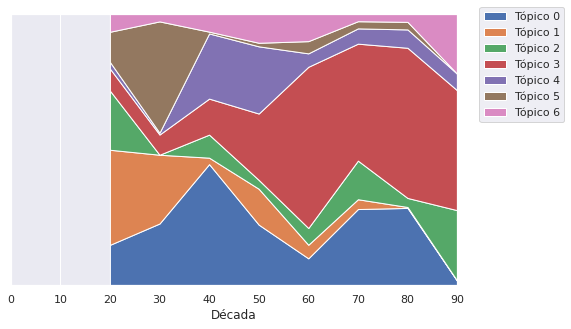

In [ ]:
# El eje x es la década
x = df_decada.index

# El eje y son las distribuciones
y = df_decada[['nmf_comp{}'.format(i) for i in range(n_topic_components)]].to_numpy()

plt.figure(figsize = (8,5))
plt.stackplot(x, y.T) # Stackplot: sirve para graficar distribuciones
plt.xlim([0, 90])
plt.ylim([0, 1.00])
plt.yticks([])
plt.xlabel('Década')
plt.legend(['Tópico {}'.format(i) for i in range(n_topic_components)], loc = (1.05, 0.60))
plt.show()

## Análisis de comunidad

#### Focalicémonos en la red gigante

In [ ]:
componentes= nx.connected_components(G) #tomamos las componentes de la
lista_componentes = [G.subgraph(componente) for componente in 
                     sorted(componentes, key=len, reverse=True)]
G_gigante= lista_componentes[0] #Tomo la componente gigante

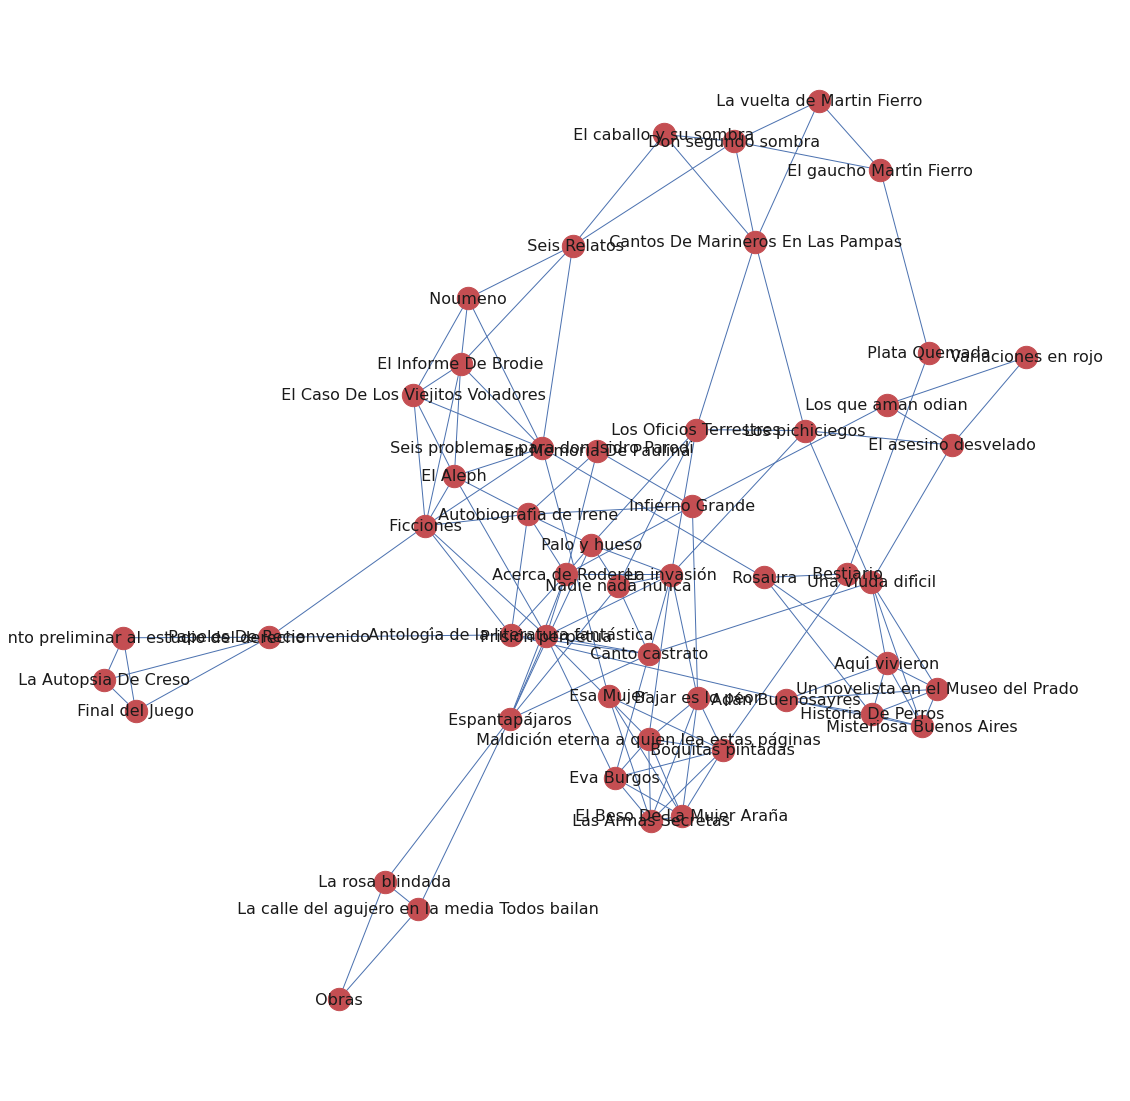

In [ ]:
fig, ax = plt.subplots(figsize = (20, 20))
ax.axis('off')
nx.draw_networkx_nodes(G_gigante, pos, node_color='r', node_size=500)
nx.draw_networkx_edges(G_gigante, pos, edge_color='b')
nx.draw_networkx_labels(G_gigante, pos, labels_titulo, font_size=16)

plt.show()



In [ ]:
grados = G.degree()

In [ ]:
dic = list(dict(grados).values())
dic.index(7)
df['Author'][24]
diametr = nx.diameter(G_gigante)
diametr

7

In [ ]:
!pip install bbox
!apt-get install libcairo2-dev libjpeg-dev libgif-dev
!pip install pycairo
!pip install igraph
!pip install python-louvain


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Reading package lists... Done
Building dependency tree       
Reading state information... Done
libjpeg-dev is already the newest version (8c-2ubuntu8).
libjpeg-dev set to manually installed.
libgif-dev is already the newest version (5.1.4-2ubuntu0.1).
libgif-dev set to manually installed.
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
The following additional packages will be installed:
  libcairo-script-interpreter2 libpixman-1-dev libxcb-shm0-dev
Suggested packages:
  libcairo2-doc
The following NEW packages will be installed:
  libcairo-script-interpreter2 libcairo2-dev libpixman-1-dev libxcb-shm0-dev
0 upgraded, 4 newly installed, 0 to remove and 5 not upgraded.
Need to get 930 kB of archives.
After this operation, 3,986 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubu

In [ ]:
import igraph as ig
from community import community_louvain as com
import cairo # Importo Cairo
import bbox
# Esto es para que funcione Cairo
from IPython.display import SVG, display, Image
def show_svg(file):
    display(SVG(filename=file))

In [ ]:
# Fastgreedy 

G_ig = ig.Graph.from_networkx(G_gigante)
com_fg = G_ig.community_fastgreedy(weights = None)

In [ ]:
print(com_fg) # Cantidad de elementos y de mergeos hechos
print(f'La cantidad de comunas que maximiza la modularidad es: {com_fg.optimal_count}')
print(f'La modularidad de dicha partición es: {com_fg.as_clustering().modularity}')
print(f'La separación en comunas, considerando 5 comunidades es: \n {com_fg.as_clustering()}')

Dendrogram, 51 elements, 50 merges
La cantidad de comunas que maximiza la modularidad es: 7
La modularidad de dicha partición es: 0.57391357421875
La separación en comunas, considerando 5 comunidades es: 
 Clustering with 51 elements and 7 clusters
[0] 0, 15, 22, 23, 24, 34, 41, 43, 48
[1] 1, 7, 10, 40, 44, 49
[2] 2, 3, 5, 38, 39, 46
[3] 4, 6, 8, 9, 11, 13, 19, 25, 26, 30, 31, 32, 35, 36, 37, 47
[4] 12, 18, 45
[5] 14, 16, 33, 50
[6] 17, 20, 21, 27, 28, 29, 42


In [ ]:
# Infomap

com_ip = G_ig.community_infomap()

print(com_ip)

Clustering with 51 elements and 9 clusters
[0] 0, 22, 23, 24, 41, 43, 48
[1] 1, 7, 10, 15, 34, 44, 49
[2] 2, 3, 5, 38, 39, 40, 46
[3] 4, 6, 8, 11, 13
[4] 9, 19, 25, 26, 30, 31, 32, 37
[5] 12, 18, 45
[6] 14, 16, 33, 50
[7] 17, 20, 21, 27, 28, 29, 42
[8] 35, 36, 47


In [ ]:
# Función para llevar el objeto vertex cluster a diccionario
def cluster_to_dict(cluster, g):
    dic = {}
    for i, c in enumerate(sorted(list(cluster), key = len, reverse = True)):
        for n in c:
            dic[g.vs[n]['_nx_name']] = i
    return dic


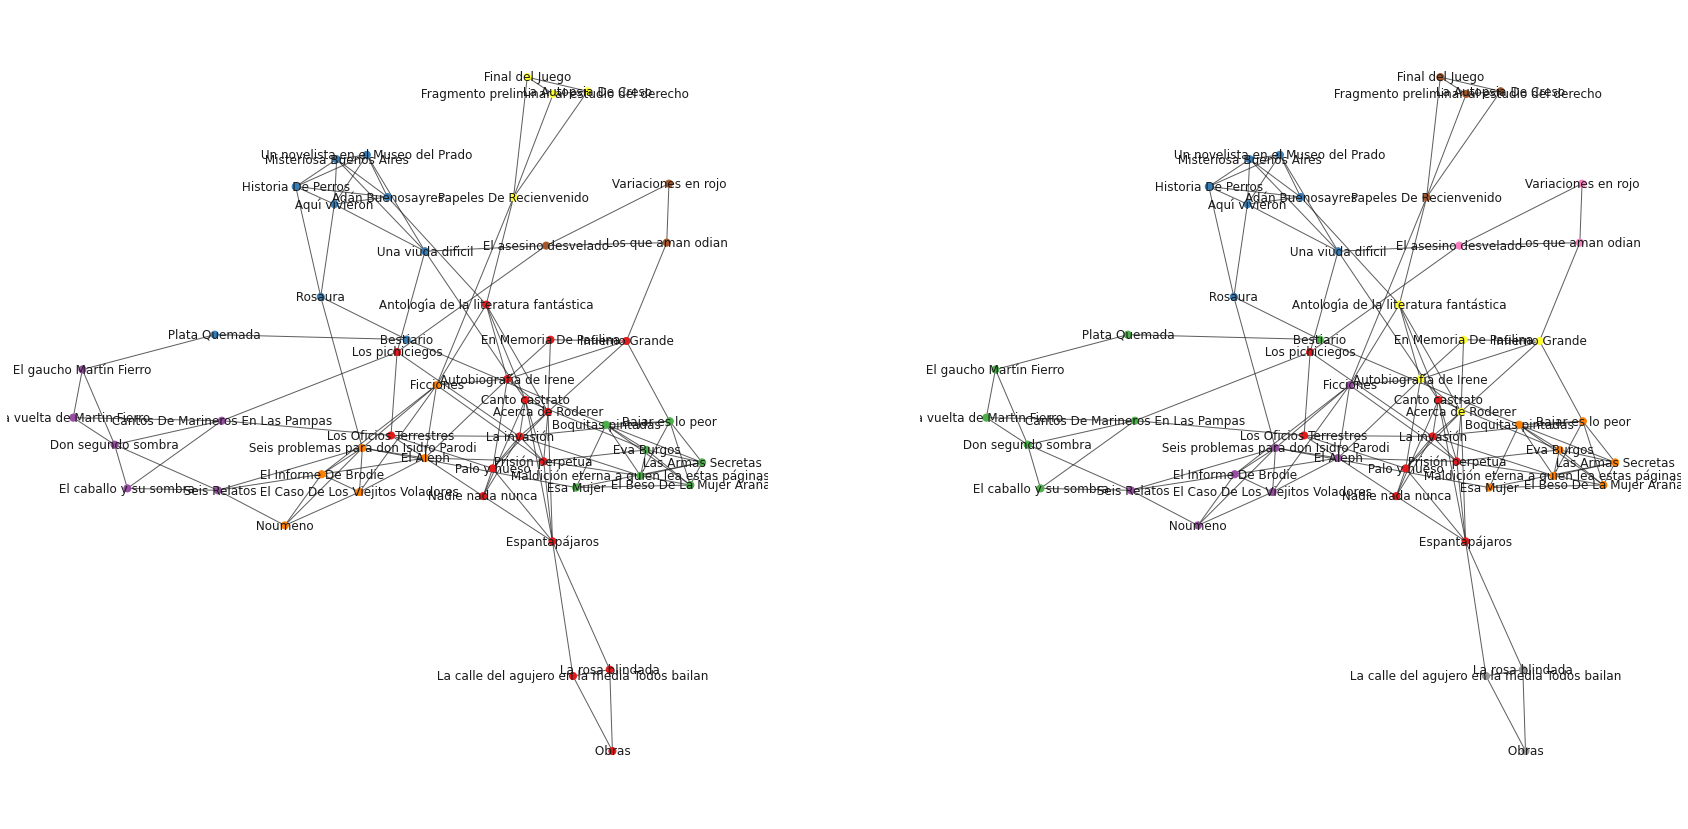

In [ ]:
pos = nx.layout.fruchterman_reingold_layout(G_gigante)

dic_com_fg = cluster_to_dict(com_fg.as_clustering(), G_ig)
dic_com_ip = cluster_to_dict(com_ip, G_ig)
particiones = [dic_com_fg, dic_com_ip]

fig, axs = plt.subplots(1, 2, figsize = (30, 15))

for i, ax in enumerate(fig.axes):
    nx.draw_networkx_nodes(G_gigante,
                           pos = pos,
                           node_color = [plt.get_cmap('Set1')(particiones[i][v]) for v in G_gigante.nodes()],
                           ax = ax,
                           node_size = 50)
    nx.draw_networkx_edges(G_gigante,
                           pos = pos,
                           ax = ax,
                           alpha = .7)
    nx.draw_networkx_labels(G_gigante,
                       pos = pos,
                       ax = ax,
                       labels = {v: str(df['Title'][v]) for v in G_gigante.nodes()})
    ax.axis('off')

plt.show()


In [ ]:
#centralidad y letalidad


def abrir_esenciales(nombre_archivo):
    archivo = open(nombre_archivo)
    data = []
    for linea in archivo:
        linea=linea.strip()
        columna=linea.split()
        data.append(columna)  
    data = data[2:]
    esenciales = []
    for linea in data:
      if len(linea)>2:
        esenciales.append(linea[1])
    return(esenciales)


def segundo_elemento(lista):
  return lista[1]

def hacer_lista_grados_ordenada(Red):
  grados = Red.degree()
  grados = list(grados)
  grados.sort(key = segundo_elemento, reverse = True)
  return [nodo for (nodo,grado) in grados]

def ordenar_diccionario_por_valor(diccionario):
  return [key for key, value in sorted(diccionario.items(), key=lambda item: item[1], reverse=True)]



In [ ]:
Red = G.copy()
diccionario_centralidad_grado = nx.degree_centrality(Red)
diccionario_centralidad_intermediatez = nx.betweenness_centrality(Red, k=None, normalized=True, weight=None, endpoints=False, seed=None)
diccionario_centralidad_autovalor = nx.eigenvector_centrality(Red, max_iter=100, tol=1e-06, nstart=None, weight='weight')
diccionario_centralidad_cercania = nx.closeness_centrality(Red, u=None, distance=None, wf_improved=True)


def sacar_max_centralidad_degree(Red):
  # Calcula la centralidad de autovalor
  centralidad = nx.degree_centrality(Red)
  # Devuelve el nodo de máxima centralidad
  return max(centralidad, key=centralidad.get)

def sacar_max_centralidad_betweenness(Red):
  # Calcula la centralidad de autovalor
  centralidad = nx.betweenness_centrality(Red, k=None, normalized=True, weight=None, endpoints=False, seed=None)
  # Devuelve el nodo de máxima centralidad
  return max(centralidad, key=centralidad.get)

def sacar_max_centralidad_eigenvalue(Red):
  # Calcula la centralidad de autovalor
  centralidad = nx.eigenvector_centrality(Red, max_iter=100, tol=1e-06, nstart=None, weight='weight')
  # Devuelve el nodo de máxima centralidad
  return max(centralidad, key=centralidad.get)

def sacar_max_centralidad_closeness(Red):
  # Calcula la centralidad de autovalor
  centralidad = nx.closeness_centrality(Red, u=None, distance=None, wf_improved=True)
  # Devuelve el nodo de máxima centralidad
  return max(centralidad, key=centralidad.get)
print('Obras de Mayor centralidad segun la centralidad analizada')
print('Grado:',labels_titulo[sacar_max_centralidad_degree(G)],labels_autores[sacar_max_centralidad_degree(G)])
print('Intermediatez:',labels_titulo[sacar_max_centralidad_betweenness(G)],labels_autores[sacar_max_centralidad_betweenness(G)])
print('Autovalor:',labels_titulo[sacar_max_centralidad_eigenvalue(G)],labels_autores[sacar_max_centralidad_eigenvalue(G)])
print('Cercania:',labels_titulo[sacar_max_centralidad_closeness(G)],labels_autores[sacar_max_centralidad_closeness(G)])


Obras de Mayor centralidad segun la centralidad analizada
Grado:  La invasión  Ricardo Piglia 
Intermediatez:  Ficciones  Borges, Jorge Luis 
Autovalor:  Prisión perpetua  Ricardo Piglia 
Cercania:  Prisión perpetua  Ricardo Piglia 


In [ ]:
labels = {v: str(df['Author'][v]) for v in G_gigante.nodes()}
labels

{0: 'Conrado Nalé Roxlo ',
 1: 'Jose Hernandez ',
 2: 'Bioy, Casares Adolfo ',
 3: 'Bioy, Casares Adolfo ',
 4: 'Bioy, Casares Adolfo ',
 5: 'Bustos, Honorio Domecq ',
 6: 'Martinez, Guillermo ',
 7: 'Fogwill, Rodolfo Enrique ',
 8: 'Martínez, Guillermo ',
 9: 'Fogwill, Rodolfo Enrique ',
 10: 'José, Hernández ',
 11: 'Bioy, Casares Adolfo . Borges, Jorge Luis . Ocampo, Silvina ',
 12: 'Bioy, Casares Adolfo . Ocampo, Silvina ',
 13: 'Ocampo, Silvina ',
 14: 'Fernandez, Macedonio ',
 15: 'Cortazar, Julio ',
 16: 'Cortazar, Julio ',
 17: 'Cortazar, Julio ',
 18: 'Rodlfo Walsh ',
 19: 'Rodolfo Walsh ',
 20: 'Enríquez, Mariana ',
 21: 'Walsh, Rodolfo ',
 22: 'Manuel Mujica Láinez ',
 23: 'Manuel Mujica Láinez ',
 24: 'Manuel Mujica Láinez ',
 25: 'Ricardo Piglia ',
 26: 'Ricardo Piglia ',
 27: 'Puig, Manuel ',
 28: 'Puig, Manuel ',
 29: 'Puig, Manuel ',
 30: 'Juan Jose Saer ',
 31: 'César Aira ',
 32: 'Juan José Saer ',
 33: 'Juan Bautista Alberdi ',
 34: 'Ricardo Piglia ',
 38: 

In [ ]:
dic_com_fg

{3: 0,
 4: 0,
 8: 0,
 11: 0,
 36: 0,
 42: 0,
 45: 0,
 55: 0,
 56: 0,
 62: 0,
 66: 0,
 67: 0,
 68: 0,
 69: 0,
 70: 0,
 71: 0,
 6: 1,
 13: 1,
 20: 1,
 24: 1,
 41: 1,
 50: 1,
 58: 1,
 59: 1,
 60: 1,
 61: 1,
 65: 1,
 23: 2,
 35: 2,
 39: 2,
 47: 2,
 48: 2,
 51: 2,
 52: 2,
 53: 2,
 63: 2,
 64: 2,
 1: 3,
 5: 3,
 9: 3,
 10: 3,
 15: 3,
 21: 3,
 22: 3,
 31: 3,
 37: 3,
 7: 4,
 16: 4,
 17: 4,
 18: 4,
 25: 4,
 26: 4,
 27: 4,
 40: 4,
 54: 4,
 12: 5,
 43: 5,
 44: 5,
 46: 5,
 57: 5,
 0: 6,
 19: 6,
 29: 6,
 30: 6}

In [ ]:
#Red Negra que queda piola
pos = nx.spring_layout(G)
fig, ax = plt.subplots(figsize = (50, 40))
ax.axis('off')
nx.draw_networkx_nodes(G, pos, node_color='skyblue', node_size=1000)
nx.draw_networkx_edges(G, pos, edge_color='white')
nx.draw_networkx_labels(G, pos, labels_titulos, font_size=13, font_color='white')
fig.set_facecolor("#00000F")
#nx.draw(G, with_labels=True)
plt.show()